# Borzoi vs Alphagenome

### Dataset
- **15 genes** from chromosome 20
- **Same variants** analyzed by both models
- **Cached comparison data** from both FlashZoi (Borzoi-based) and Alphagenome predictions


In [14]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
import base64
from pathlib import Path
import scanpy as sc
from scipy.sparse import issparse

from IPython.display import HTML, display

cache_file = "../../data/intermediate/dataset1/gene_stats_cached.tsv"
var_df = pd.read_csv(cache_file, sep="\t")


What do we get from alphagenome for per SNP?

Shape (genes × biosamples): (1, 546)

Variant interval : chr20:51929653-52453941:.
Variant details  : chr20:51930096:C>G
Scorer metadata  : CenterMaskScorer(requested_output=CAGE, width=501, aggregation_type=DIFF_LOG2_SUM) 

Top 10 biosamples with highest predicted cis-variance

                       biosample_name  predicted_cis_variance
0                   fungiform papilla                0.073930
1                      vitreous humor                0.051838
2                   fungiform papilla                0.048126
3                umbilical cord blood                0.045013
4  lateral rectus extra-ocular muscle                0.044507
5                          nail plate                0.044038
6                      vitreous humor                0.042192
7                         bone marrow                0.042009
8           cruciate ligament of knee                0.041199
9    medial rectus extraocular muscle                0.041048

Prediction summary:
count    546.0000

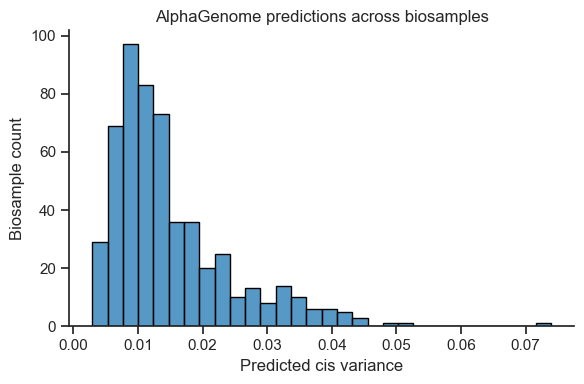

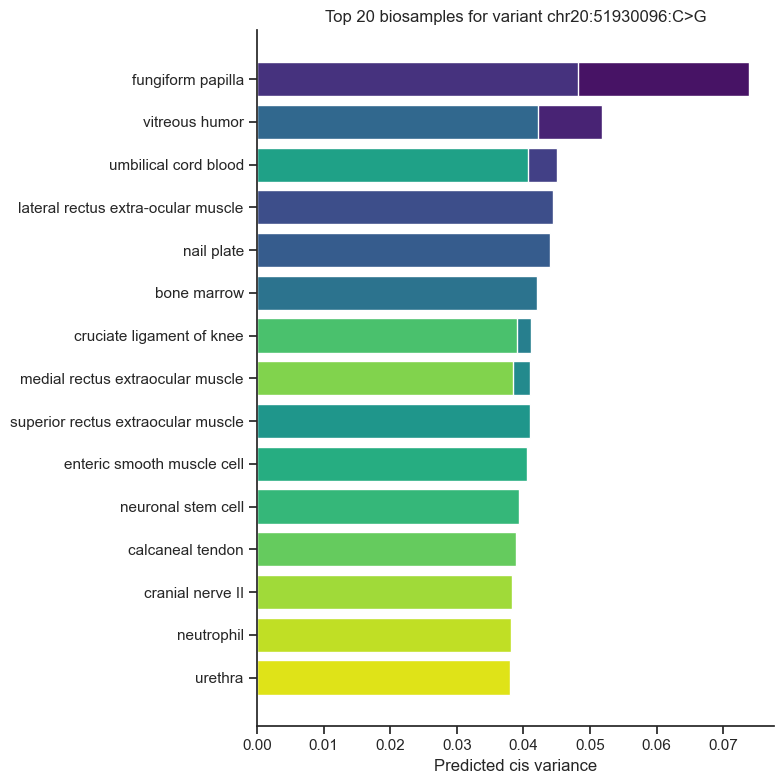

In [11]:
f = "../../data/intermediate/dataset1/alphagenome/ENSG00000020256_51930096_C>G.h5ad"

sns.set_theme(style="ticks",
              rc={"axes.spines.right": False, "axes.spines.top": False})

adata = sc.read_h5ad(f)

print(f"Shape (genes × biosamples): {adata.shape}\n")

print("Variant interval :", adata.uns.get("interval"))
print("Variant details  :", adata.uns.get("variant"))
print("Scorer metadata  :", adata.uns.get("variant_scorer"), "\n")

values = adata.X.A1 if issparse(adata.X) else np.asarray(adata.X).flatten()

df = adata.var.loc[:, ["biosample_name", "ontology_curie", "Assay title"]].copy()
df.rename(columns={"Assay title": "assay"}, inplace=True)
df["predicted_cis_variance"] = values
df = df.sort_values("predicted_cis_variance", ascending=False).reset_index(drop=True)

print("Top 10 biosamples with highest predicted cis-variance\n")
print(df.head(10)[["biosample_name", "predicted_cis_variance"]])

print("\nPrediction summary:")
print(df["predicted_cis_variance"].describe(percentiles=[.1, .25, .5, .75, .9]))

plt.figure(figsize=(6, 4))
sns.histplot(df["predicted_cis_variance"], bins=30,
             edgecolor="black", color="#1f77b4")
plt.xlabel("Predicted cis variance")
plt.ylabel("Biosample count")
plt.title("AlphaGenome predictions across biosamples")
plt.tight_layout()
plt.show()

top_n = 20
top_df = df.head(top_n)

fig, ax = plt.subplots(figsize=(8, 0.35 * top_n + 1))  # height scales with N
ax.barh(top_df["biosample_name"], top_df["predicted_cis_variance"],
        color=sns.color_palette("viridis", n_colors=top_n))
ax.set_xlabel("Predicted cis variance")
ax.set_ylabel("")
ax.invert_yaxis()   # highest at top
variant_label = adata.uns.get("variant")
ax.set_title(f"Top {top_n} biosamples for variant {variant_label}")
plt.tight_layout()
plt.show()

## 1. Comparison of Borzoi and Alphagenome predicted cis-variances


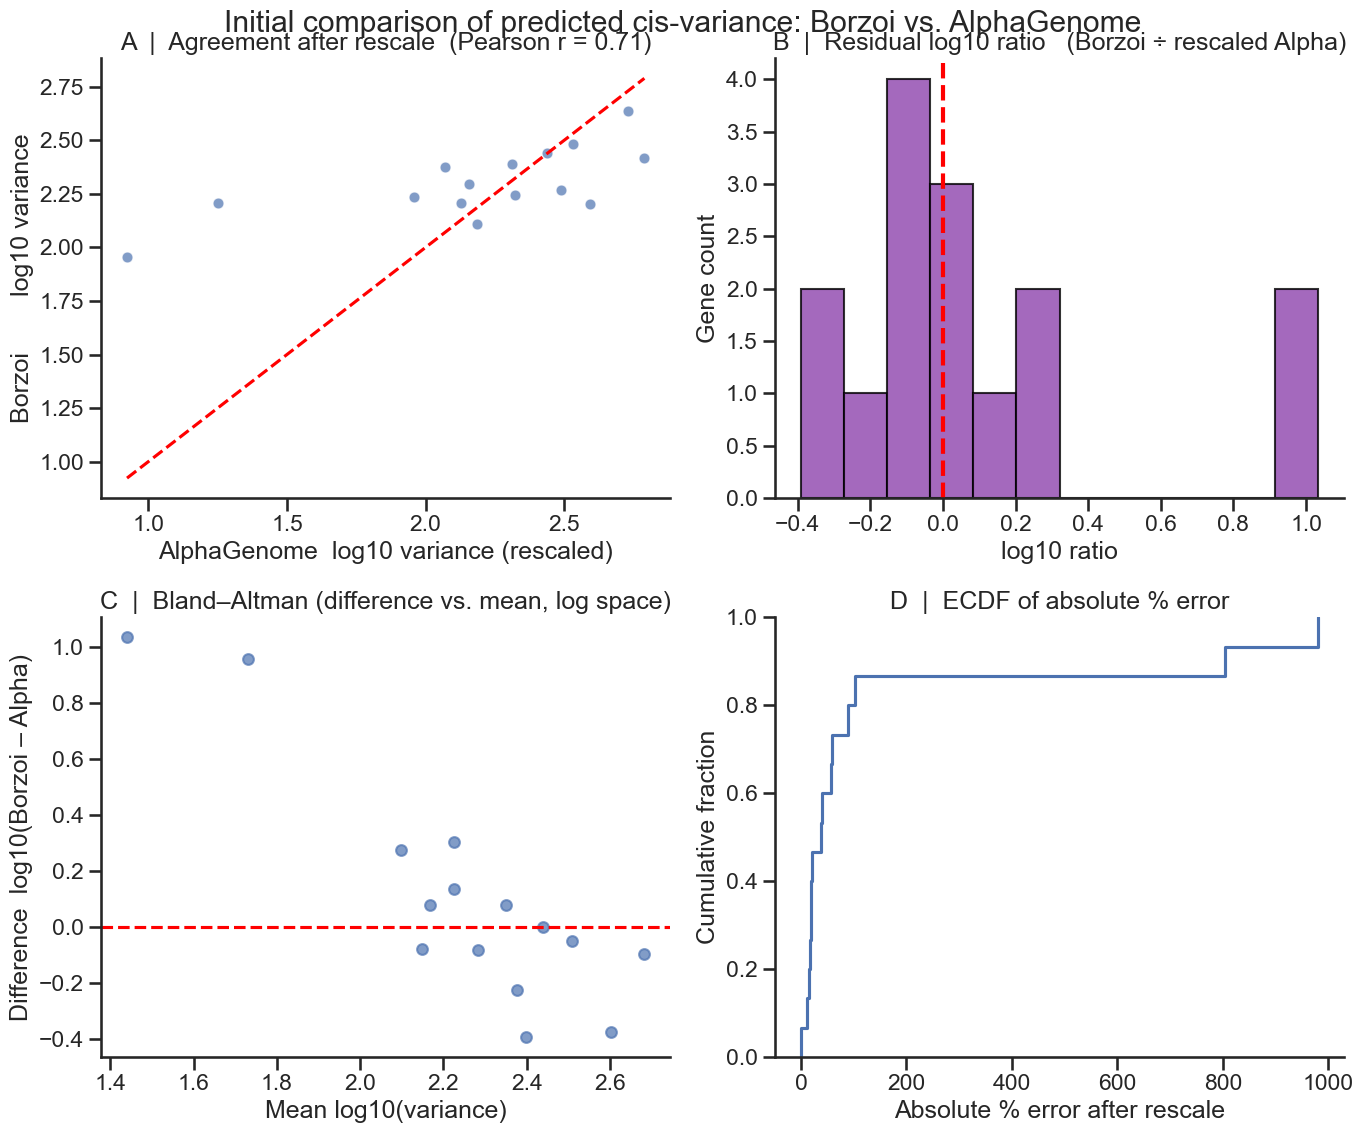


Median & IQR before / after rescale
              median_raw  median_log  median_rescaled    IQR_raw
Borzoi       184.422547    2.265814              NaN  91.346500
AlphaGenome    1.084487    0.035225       205.069491   1.048228

Multiplicative scale factor used: 189.1×  (median log gap 2.28 dex)


In [12]:
sns.set_theme(context="talk", style="ticks",
              rc={"axes.spines.right": False, "axes.spines.top": False})

OUT = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset1/comparison_figs")
OUT.mkdir(parents=True, exist_ok=True)
save = lambda f,n: f.savefig(OUT/f"{n}.png", dpi=300, bbox_inches="tight")

# quick rescale 
EPS = 1e-6
var_df["var_borzoi_log"] = np.log10(var_df.predicted_cis_variance_borzoi + EPS)
var_df["var_alpha_log"]  = np.log10(var_df.predicted_cis_variance_alpha  + EPS)

med_gap   = (var_df.var_borzoi_log - var_df.var_alpha_log).median()
scale_fac = 10**med_gap                           

var_df["alpha_rescaled"] = var_df.predicted_cis_variance_alpha * scale_fac
var_df["alpha_rescaled_log"] = var_df.var_alpha_log + med_gap    

fig, ax = plt.subplots(2, 2, figsize=(14,12))
axs = ax.flatten()

# scatter on log scale
sns.scatterplot(x=var_df.alpha_rescaled_log, y=var_df.var_borzoi_log,
                ax=axs[0], s=60, alpha=.7)
axs[0].plot([var_df.alpha_rescaled_log.min(), var_df.alpha_rescaled_log.max()],
            [var_df.alpha_rescaled_log.min(), var_df.alpha_rescaled_log.max()],
            ls="--", c="red")
r, _ = pearsonr(var_df.alpha_rescaled_log, var_df.var_borzoi_log)
axs[0].set_title(f"A  |  Agreement after rescale  (Pearson r = {r:.2f})")
axs[0].set_xlabel("AlphaGenome  log10 variance (rescaled)")
axs[0].set_ylabel("Borzoi        log10 variance")

# histogram of residual log ratio
log_ratio = var_df.var_borzoi_log - var_df.alpha_rescaled_log
axs[1].hist(log_ratio, bins=12, color="#8E44AD", edgecolor="black", alpha=.8)
axs[1].axvline(log_ratio.median(), ls="--", lw=3, c="red")
axs[1].set_title("B  |  Residual log10 ratio   (Borzoi ÷ rescaled Alpha)")
axs[1].set_xlabel("log10 ratio")
axs[1].set_ylabel("Gene count")

# Bland–Altman
mean_log = (var_df.var_borzoi_log + var_df.alpha_rescaled_log) / 2
diff_log = var_df.var_borzoi_log - var_df.alpha_rescaled_log
axs[2].scatter(mean_log, diff_log, alpha=.7, s=60)
axs[2].axhline(0, ls="--", c="red")
axs[2].set_title("C  |  Bland–Altman (difference vs. mean, log space)")
axs[2].set_xlabel("Mean log10(variance)")
axs[2].set_ylabel("Difference  log10(Borzoi – Alpha)")

# cumulative % error
pct_err = 100 * (10**diff_log - 1).abs()
sns.ecdfplot(pct_err, ax=axs[3])
axs[3].set_xlabel("Absolute % error after rescale")
axs[3].set_ylabel("Cumulative fraction")
axs[3].set_title("D  |  ECDF of absolute % error")

for a in axs: sns.despine(ax=a)
fig.suptitle("Initial comparison of predicted cis-variance: Borzoi vs. AlphaGenome", y=.95)
plt.tight_layout()
save(fig, "borzoi_vs_alphagenome_initial_comparison")
plt.show()

summary = pd.DataFrame({
    "median_raw": [var_df.predicted_cis_variance_borzoi.median(),
                   var_df.predicted_cis_variance_alpha.median()],
    "median_log": [var_df.var_borzoi_log.median(),
                   var_df.var_alpha_log.median()],
    "median_rescaled": [np.nan,
                        var_df.alpha_rescaled.median()],
    "IQR_raw"  : [var_df.predicted_cis_variance_borzoi.quantile(.75) -
                  var_df.predicted_cis_variance_borzoi.quantile(.25),
                  var_df.predicted_cis_variance_alpha.quantile(.75) -
                  var_df.predicted_cis_variance_alpha.quantile(.25)]
}, index=["Borzoi","AlphaGenome"])
print("\nMedian & IQR before / after rescale\n", summary)
print(f"\nMultiplicative scale factor used: {scale_fac:.1f}×  (median log gap {med_gap:.2f} dex)")

Still pretty messy — even after rescaling, the two methods disagree too much

## 2. do models agree on gene rankings?


MODEL AGREEMENT ANALYSIS
Pearson correlation:  r = 0.678 (p = 0.005)
Spearman correlation: ρ = 0.593 (p = 0.020)


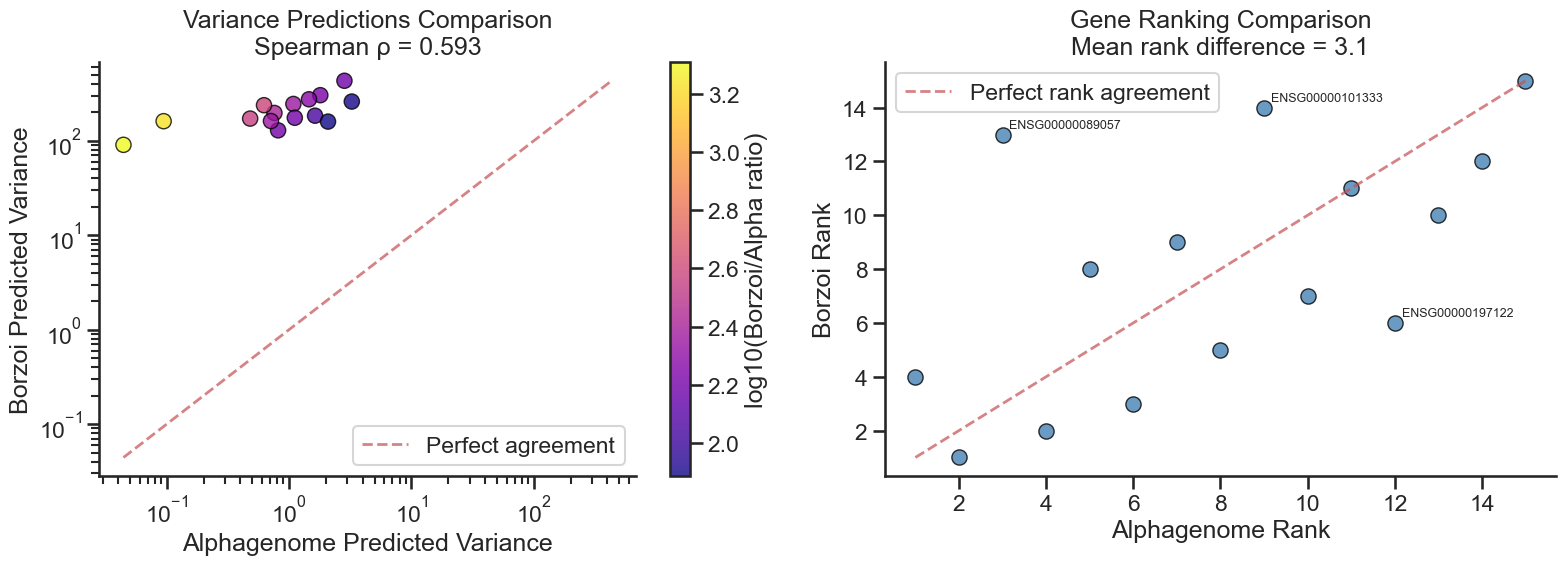


Genes with largest ranking disagreements:
  ENSG00000089057: Borzoi rank 13, Alpha rank 3 (diff: 10)
  ENSG00000197122: Borzoi rank 6, Alpha rank 12 (diff: 6)
  ENSG00000101333: Borzoi rank 14, Alpha rank 9 (diff: 5)


In [56]:
pearson_r, pearson_p = pearsonr(var_df["predicted_cis_variance_borzoi"], var_df["predicted_cis_variance_alpha"])
spearman_r, spearman_p = spearmanr(var_df["predicted_cis_variance_borzoi"], var_df["predicted_cis_variance_alpha"])

var_df['borzoi_rank'] = var_df['predicted_cis_variance_borzoi'].rank(ascending=False, method='min')
var_df['alpha_rank'] = var_df['predicted_cis_variance_alpha'].rank(ascending=False, method='min')
var_df['rank_diff'] = abs(var_df['borzoi_rank'] - var_df['alpha_rank'])

print("MODEL AGREEMENT ANALYSIS")
print("=" * 30)
print(f"Pearson correlation:  r = {pearson_r:.3f} (p = {pearson_p:.3f})")
print(f"Spearman correlation: ρ = {spearman_r:.3f} (p = {spearman_p:.3f})")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter = axes[0].scatter(var_df["predicted_cis_variance_alpha"], 
                         var_df["predicted_cis_variance_borzoi"],
                         c=np.log10(var_df["variance_ratio"]), 
                         cmap="plasma", s=120, alpha=0.8, edgecolors='black', linewidth=1)

# adding 1:1 line (if they were equal)
min_val = min(var_df["predicted_cis_variance_alpha"].min(), var_df["predicted_cis_variance_borzoi"].min())
max_val = max(var_df["predicted_cis_variance_alpha"].max(), var_df["predicted_cis_variance_borzoi"].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2, label='Perfect agreement')

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Alphagenome Predicted Variance')
axes[0].set_ylabel('Borzoi Predicted Variance')
axes[0].set_title(f'Variance Predictions Comparison\nSpearman ρ = {spearman_r:.3f}')
axes[0].legend()

cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('log10(Borzoi/Alpha ratio)')

# Ranking comparison
axes[1].scatter(var_df['alpha_rank'], var_df['borzoi_rank'], s=120, alpha=0.8, 
               c='steelblue', edgecolors='black', linewidth=1)
axes[1].plot([1, 15], [1, 15], 'r--', alpha=0.7, linewidth=2, label='Perfect rank agreement')
axes[1].set_xlabel('Alphagenome Rank')
axes[1].set_ylabel('Borzoi Rank')
axes[1].set_title(f'Gene Ranking Comparison\nMean rank difference = {var_df["rank_diff"].mean():.1f}')
axes[1].legend()

# Label disagreement outliers
for _, row in var_df.query('rank_diff > 4').iterrows():
    axes[1].annotate(row['gene_id'].split('.')[0], 
                    (row['alpha_rank'], row['borzoi_rank']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

# Show biggest disagreements
print(f"\nGenes with largest ranking disagreements:")
disagreements = var_df.nlargest(3, 'rank_diff')[['gene_id', 'borzoi_rank', 'alpha_rank', 'rank_diff']]
for _, row in disagreements.iterrows():
    print(f"  {row['gene_id'].split('.')[0]}: Borzoi rank {row['borzoi_rank']:.0f}, Alpha rank {row['alpha_rank']:.0f} (diff: {row['rank_diff']:.0f})")


no they don't:DDDDDDD

Borzoi and AlphaGenome track each other quite bad (r ≈ 0.68, ρ ≈ 0.59). Borzoi generally predicts larger variances.

Most genes differ by just a few rank positions (mean shift ≈ 3), but three stand-out genes jump 5–10 places, signalling disagreement.

So the methods are fine for broad trend spotting, yet still unreliable for picking a definitive “top hit”. 


## Ranks

Spearman ρ  = 0.593
Kendall τ   = 0.467
Mean rank shift = 3.07 positions
Top-5 overlap (Jaccard) = 0.43
Top-10 overlap (Jaccard) = 0.67
Top-20 overlap (Jaccard) = 1.00


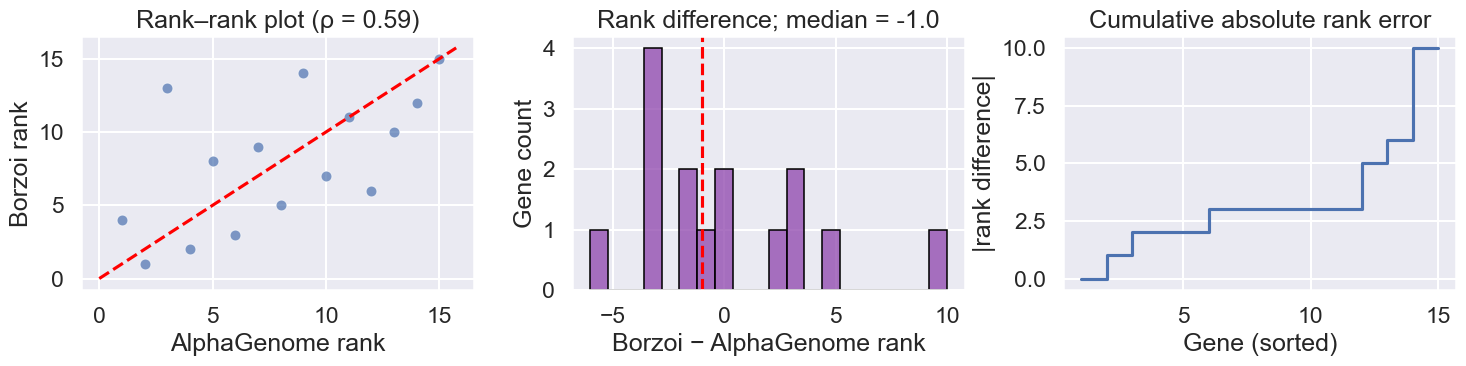

In [15]:
var_df = var_df.copy()
var_df["rank_borzoi"] = var_df["predicted_cis_variance_borzoi"].rank(ascending=False, method="min")
var_df["rank_alpha"]  = var_df["predicted_cis_variance_alpha"].rank(ascending=False, method="min")

sub = var_df

rho,   _ = spearmanr(sub["rank_borzoi"], sub["rank_alpha"])
tau,   _ = kendalltau(sub["rank_borzoi"], sub["rank_alpha"])
mean_abs_shift = np.mean(np.abs(sub["rank_borzoi"] - sub["rank_alpha"]))

print(f"Spearman ρ  = {rho:.3f}")
print(f"Kendall τ   = {tau:.3f}")
print(f"Mean rank shift = {mean_abs_shift:.2f} positions")

# overlap for several k
for k in (5, 10, 20):
    top_borzoi = set(sub.nsmallest(k, "rank_borzoi").index)
    top_alpha  = set(sub.nsmallest(k, "rank_alpha").index)
    jaccard = len(top_borzoi & top_alpha) / len(top_borzoi | top_alpha)
    print(f"Top-{k} overlap (Jaccard) = {jaccard:.2f}")


plt.figure(figsize=(15,4))

# scatter of ranks
plt.subplot(1,3,1)
sns.scatterplot(x="rank_alpha", y="rank_borzoi", data=sub, s=60, alpha=.7)
lim = [0, sub[["rank_borzoi","rank_alpha"]].values.max()*1.05]
plt.plot(lim, lim, ls="--", c="red")
plt.xlabel("AlphaGenome rank"); plt.ylabel("Borzoi rank")
plt.title(f"Rank–rank plot (ρ = {rho:.2f})")

# histogram of rank differences
plt.subplot(1,3,2)
diff = sub["rank_borzoi"] - sub["rank_alpha"]
sns.histplot(diff, bins=20, color="#8E44AD", edgecolor="black")
plt.axvline(diff.median(), c="red", ls="--")
plt.xlabel("Borzoi − AlphaGenome rank"); plt.ylabel("Gene count")
plt.title(f"Rank difference; median = {diff.median():.1f}")

# cumulative absolute rank error
plt.subplot(1,3,3)
abs_err = np.abs(diff).sort_values()
plt.step(range(1, len(abs_err)+1), abs_err)
plt.xlabel("Gene (sorted)"); plt.ylabel("|rank difference|")
plt.title("Cumulative absolute rank error")

plt.tight_layout()
plt.show()

Borzoi and AlphaGenome sort the genes pretty somewhat but not perfectly.

On average a gene moves about three spots between the two lists, and they agree on only 2 of the very top-5 genes, though by the top-20 their lists completely overlap.

So maybe we can trust them for a broad shortlist, but we shouldn't rely on them for the exact top winners

## 3. Summary


In [63]:
summary_stats = {
    'Metric': [
        'Median Variance Ratio (Borzoi/Alpha)',
        'Median Effect Size Ratio (|Δ|)',
        'Spearman Rank Correlation',
        'Genes with Large Rank Disagreement (>4)',
        'Mean Absolute Rank Difference'
    ],
    'Value': [
        f"{var_df['variance_ratio'].median():.0f}x",
        f"{var_df['effect_ratio'].median():.0f}x",
        f"{spearman_r:.3f}",
        f"{(var_df['rank_diff'] > 4).sum()}/15",
        f"{var_df['rank_diff'].mean():.1f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)

print("Summary stats")
print("=" * 45)
for _, row in summary_df.iterrows():
    print(f"{row['Metric']:<40} {row['Value']}")

print(f"\n Gene comparison (top 10 by variance ratio):")
print("=" * 80)
print(f"{'Gene':<12} {'Borzoi Var':<12} {'Alpha Var':<12} {'Ratio':<8} {'B_Rank':<8} {'A_Rank':<8} {'R_Diff':<6}")
print("-" * 80)
for _, row in comparison_table.head(10).iterrows():
    print(f"{row['gene_id']:<12} {row['predicted_cis_variance_borzoi']:<12.1f} "
          f"{row['predicted_cis_variance_alpha']:<12.3f} {row['variance_ratio']:<8.0f} "
          f"{row['borzoi_rank']:<8.0f} {row['alpha_rank']:<8.0f} {row['rank_diff']:<6.0f}")

Summary stats
Median Variance Ratio (Borzoi/Alpha)     189x
Median Effect Size Ratio (|Δ|)           541x
Spearman Rank Correlation                0.593
Genes with Large Rank Disagreement (>4)  3/15
Mean Absolute Rank Difference            3.1

 Gene comparison (top 10 by variance ratio):
Gene         Borzoi Var   Alpha Var    Ratio    B_Rank   A_Rank   R_Diff
--------------------------------------------------------------------------------
ENSG00000089123 90.6         0.044        2044     15       15       0     
ENSG00000020256 161.2        0.094        1708     12       14       2     
ENSG00000197122 238.1        0.624        382      6        12       6     
ENSG00000101052 171.8        0.481        357      10       13       3     
ENSG00000131061 197.1        0.759        260      7        10       3     
ENSG00000171940 161.8        0.711        228      11       11       0     
ENSG00000077984 245.5        1.084        226      5        8        3     
ENSG00000158445 275.1   

## 3. Validation against Philipp's dataset (using them as ground truth)

### 3.1 Comparing in silico predictions with population-derived expression variability

Checking whether our predicted gene-level variances (from both Borzoi and Alphagenome) can correctly order genes by real-world variability (VG) from GTEx muscle tissue data.


In [43]:
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources"
robjects.r['load']("../../data/initial/vg_hi.rda")
vg_df = pandas2ri.rpy2py(robjects.r['vg_hi'])

# Process for Muscle tissue ("MSCLSK") - population-level cis-regulatory expression variance
vg_df = vg_df.reset_index().rename(columns={"index": "gene_id", "MSCLSK": "VG_Muscle"})
vg_df = vg_df[["gene_id", "VG_Muscle"]].dropna()

vg_df["gene_base"] = vg_df["gene_id"].str.split(".").str[0]

print(f"Loaded VG data for {len(vg_df)} genes")
print("VG_Muscle range:", vg_df["VG_Muscle"].describe())

if "gene_base" not in var_df.columns:
    var_df["gene_base"] = var_df["gene_id"].str.replace(r"\.\d+$", "", regex=True)

merged_vg = var_df.merge(
    vg_df[["gene_base", "VG_Muscle"]],
    left_on="gene_base", right_on="gene_base", how="inner"
)

print(f"\nMerged dataset shape: {merged_vg.shape}")
print(f"Successfully matched {len(merged_vg)} genes with VG data")

validation_cols = ["gene_id", "predicted_cis_variance_borzoi", "predicted_cis_variance_alpha", "VG_Muscle"]
print("\nData preview:")
print(merged_vg[validation_cols].head())


Loaded VG data for 26779 genes
VG_Muscle range: count    26779.000000
mean         0.253991
std          0.768171
min          0.000025
25%          0.012517
50%          0.043836
75%          0.156375
max         14.914050
Name: VG_Muscle, dtype: float64

Merged dataset shape: (15, 30)
Successfully matched 15 genes with VG data

Data preview:
           gene_id  predicted_cis_variance_borzoi  \
0  ENSG00000131061                     197.062469   
1  ENSG00000197122                     238.118638   
2  ENSG00000196839                     260.276776   
3  ENSG00000170191                     184.422547   
4  ENSG00000101333                     129.060822   

   predicted_cis_variance_alpha  VG_Muscle  
0                      0.759239   0.007140  
1                      0.623977   0.029678  
2                      3.255609   0.012538  
3                      1.631400   0.014181  
4                      0.813520   0.011003  


### 3.2 Normalize Predictions for Comparison

In [48]:
from sklearn.preprocessing import StandardScaler

merged_vg["borzoi_norm"] = (merged_vg["predicted_cis_variance_borzoi"] - 
                           merged_vg["predicted_cis_variance_borzoi"].min()) / \
                          (merged_vg["predicted_cis_variance_borzoi"].max() - 
                           merged_vg["predicted_cis_variance_borzoi"].min())

merged_vg["alpha_norm"] = (merged_vg["predicted_cis_variance_alpha"] - 
                          merged_vg["predicted_cis_variance_alpha"].min()) / \
                         (merged_vg["predicted_cis_variance_alpha"].max() - 
                          merged_vg["predicted_cis_variance_alpha"].min())

merged_vg["vg_norm"] = (merged_vg["VG_Muscle"] - merged_vg["VG_Muscle"].min()) / \
                      (merged_vg["VG_Muscle"].max() - merged_vg["VG_Muscle"].min())

print("Scale comparison (raw values):")
print(f"Borzoi variance range: {merged_vg['predicted_cis_variance_borzoi'].min():.2f} - {merged_vg['predicted_cis_variance_borzoi'].max():.2f}")
print(f"Alpha variance range: {merged_vg['predicted_cis_variance_alpha'].min():.6f} - {merged_vg['predicted_cis_variance_alpha'].max():.6f}")
print(f"VG_Muscle range: {merged_vg['VG_Muscle'].min():.6f} - {merged_vg['VG_Muscle'].max():.6f}")

print("\nAfter normalization (0-1 scale):")
print(f"Borzoi normalized: {merged_vg['borzoi_norm'].min():.3f} - {merged_vg['borzoi_norm'].max():.3f}")
print(f"Alpha normalized: {merged_vg['alpha_norm'].min():.3f} - {merged_vg['alpha_norm'].max():.3f}")
print(f"VG normalized: {merged_vg['vg_norm'].min():.3f} - {merged_vg['vg_norm'].max():.3f}")

norm_cols = ["gene_id", "borzoi_norm", "alpha_norm", "vg_norm"]
print("\nNormalized data preview:")
print(merged_vg[norm_cols].head())


Scale comparison (raw values):
Borzoi variance range: 90.61 - 432.00
Alpha variance range: 0.044337 - 3.255609
VG_Muscle range: 0.007140 - 0.070169

After normalization (0-1 scale):
Borzoi normalized: 0.000 - 1.000
Alpha normalized: 0.000 - 1.000
VG normalized: 0.000 - 1.000

Normalized data preview:
           gene_id  borzoi_norm  alpha_norm   vg_norm
0  ENSG00000131061     0.311822    0.222623  0.000000
1  ENSG00000197122     0.432082    0.180501  0.357585
2  ENSG00000196839     0.496986    1.000000  0.085653
3  ENSG00000170191     0.274797    0.494216  0.111712
4  ENSG00000101333     0.112635    0.239526  0.061288


### 3.3 Correlation Analysis

T whether either model can correctly rank genes by their observed expression variability using Spearman rank correlation.


In [49]:
correlations = {}

borzoi_spearman = spearmanr(merged_vg["predicted_cis_variance_borzoi"], merged_vg["VG_Muscle"])
borzoi_pearson = pearsonr(merged_vg["predicted_cis_variance_borzoi"], merged_vg["VG_Muscle"])

alpha_spearman = spearmanr(merged_vg["predicted_cis_variance_alpha"], merged_vg["VG_Muscle"])
alpha_pearson = pearsonr(merged_vg["predicted_cis_variance_alpha"], merged_vg["VG_Muscle"])

borzoi_norm_spearman = spearmanr(merged_vg["borzoi_norm"], merged_vg["vg_norm"])
alpha_norm_spearman = spearmanr(merged_vg["alpha_norm"], merged_vg["vg_norm"])

models_spearman = spearmanr(merged_vg["predicted_cis_variance_borzoi"], merged_vg["predicted_cis_variance_alpha"])
models_norm_spearman = spearmanr(merged_vg["borzoi_norm"], merged_vg["alpha_norm"])

print("=== CORRELATION RESULTS ===")
print("\nModel vs Observed VG (Raw Values):")
print(f"Borzoi vs VG_Muscle:     ρ = {borzoi_spearman[0]:.3f}, p = {borzoi_spearman[1]:.3f}")
print(f"Alphagenome vs VG_Muscle: ρ = {alpha_spearman[0]:.3f}, p = {alpha_spearman[1]:.3f}")

print("\nModel vs Observed VG (Normalized):")
print(f"Borzoi_norm vs VG_norm:     ρ = {borzoi_norm_spearman[0]:.3f}, p = {borzoi_norm_spearman[1]:.3f}")
print(f"Alpha_norm vs VG_norm:      ρ = {alpha_norm_spearman[0]:.3f}, p = {alpha_norm_spearman[1]:.3f}")

print("\nModel Agreement:")
print(f"Borzoi vs Alphagenome (raw): ρ = {models_spearman[0]:.3f}, p = {models_spearman[1]:.3f}")
print(f"Borzoi vs Alphagenome (norm): ρ = {models_norm_spearman[0]:.3f}, p = {models_norm_spearman[1]:.3f}")

correlations = {
    'borzoi_vg': borzoi_spearman[0],
    'alpha_vg': alpha_spearman[0], 
    'borzoi_alpha': models_spearman[0]
}


=== CORRELATION RESULTS ===

Model vs Observed VG (Raw Values):
Borzoi vs VG_Muscle:     ρ = 0.018, p = 0.950
Alphagenome vs VG_Muscle: ρ = -0.443, p = 0.098

Model vs Observed VG (Normalized):
Borzoi_norm vs VG_norm:     ρ = 0.018, p = 0.950
Alpha_norm vs VG_norm:      ρ = -0.443, p = 0.098

Model Agreement:
Borzoi vs Alphagenome (raw): ρ = 0.593, p = 0.020
Borzoi vs Alphagenome (norm): ρ = 0.593, p = 0.020


### Model Predictions vs Observed VG

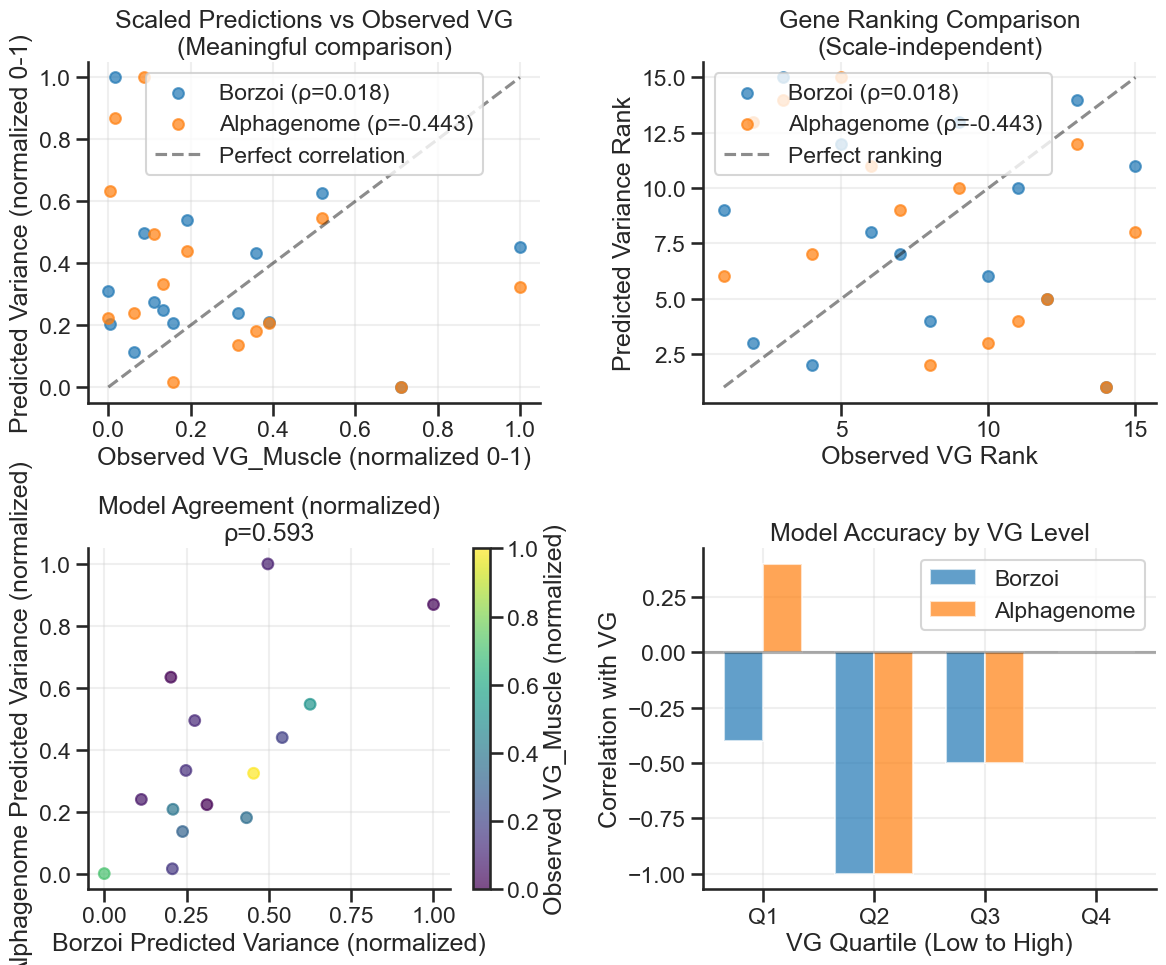

Genes analyzed: 15
Normalized correlation with VG:
borzoi:     ρ = 0.018 (p = 0.950)
alphagenome: ρ = -0.443 (p = 0.098)
Models agree (normalized): ρ = 0.593


In [64]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

borzoi_color = "#1f77b4" 
alpha_color = "#ff7f0e"   

ax1 = axes[0, 0]
ax1.scatter(merged_vg["vg_norm"], merged_vg["borzoi_norm"], 
           color=borzoi_color, alpha=0.7, s=60, label=f'Borzoi (ρ={borzoi_norm_spearman[0]:.3f})')
ax1.scatter(merged_vg["vg_norm"], merged_vg["alpha_norm"], 
           color=alpha_color, alpha=0.7, s=60, label=f'Alphagenome (ρ={alpha_norm_spearman[0]:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect correlation')
ax1.set_xlabel("Observed VG_Muscle (normalized 0-1)")
ax1.set_ylabel("Predicted Variance (normalized 0-1)")
ax1.set_title("Scaled Predictions vs Observed VG\n(Meaningful comparison)")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
merged_vg['borzoi_rank'] = merged_vg["predicted_cis_variance_borzoi"].rank()
merged_vg['alpha_rank'] = merged_vg["predicted_cis_variance_alpha"].rank()
merged_vg['vg_rank'] = merged_vg["VG_Muscle"].rank()

ax2.scatter(merged_vg['vg_rank'], merged_vg['borzoi_rank'], 
           color=borzoi_color, alpha=0.7, s=60, label=f'Borzoi (ρ={spearmanr(merged_vg["vg_rank"], merged_vg["borzoi_rank"])[0]:.3f})')
ax2.scatter(merged_vg['vg_rank'], merged_vg['alpha_rank'], 
           color=alpha_color, alpha=0.7, s=60, label=f'Alphagenome (ρ={spearmanr(merged_vg["vg_rank"], merged_vg["alpha_rank"])[0]:.3f})')

ax2.plot([1, 15], [1, 15], 'k--', alpha=0.5, label='Perfect ranking')
ax2.set_xlabel("Observed VG Rank")
ax2.set_ylabel("Predicted Variance Rank")
ax2.set_title("Gene Ranking Comparison\n(Scale-independent)")
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.scatter(merged_vg["borzoi_norm"], merged_vg["alpha_norm"], 
           c=merged_vg["vg_norm"], cmap='viridis', s=60, alpha=0.7)
cbar = plt.colorbar(ax3.collections[0], ax=ax3)
cbar.set_label('Observed VG_Muscle (normalized)')

ax3.set_xlabel("Borzoi Predicted Variance (normalized)")
ax3.set_ylabel("Alphagenome Predicted Variance (normalized)")
ax3.set_title(f"Model Agreement (normalized)\nρ={models_norm_spearman[0]:.3f}")
ax3.grid(True, alpha=0.3)

# Prediction accuracy by VG quartiles
ax4 = axes[1, 1]
merged_vg['vg_quartile'] = pd.qcut(merged_vg['VG_Muscle'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Calculate accuracy within each quartile
quartile_accuracy = []
for q in ['Q1', 'Q2', 'Q3', 'Q4']:
    mask = merged_vg['vg_quartile'] == q
    if mask.sum() > 1:
        borzoi_acc = spearmanr(merged_vg.loc[mask, 'VG_Muscle'], merged_vg.loc[mask, 'borzoi_norm'])[0]
        alpha_acc = spearmanr(merged_vg.loc[mask, 'VG_Muscle'], merged_vg.loc[mask, 'alpha_norm'])[0]
    else:
        borzoi_acc = alpha_acc = 0
    quartile_accuracy.append([q, borzoi_acc, alpha_acc])

quartile_df = pd.DataFrame(quartile_accuracy, columns=['Quartile', 'Borzoi_corr', 'Alpha_corr'])

x_pos = range(len(quartile_df))
width = 0.35
ax4.bar([x - width/2 for x in x_pos], quartile_df['Borzoi_corr'], width, 
        label='Borzoi', color=borzoi_color, alpha=0.7)
ax4.bar([x + width/2 for x in x_pos], quartile_df['Alpha_corr'], width,
        label='Alphagenome', color=alpha_color, alpha=0.7)

ax4.set_xlabel('VG Quartile (Low to High)')
ax4.set_ylabel('Correlation with VG')
ax4.set_title('Model Accuracy by VG Level')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(quartile_df['Quartile'])
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Genes analyzed: {len(merged_vg)}")
print(f"Normalized correlation with VG:")
print(f"borzoi:     ρ = {borzoi_norm_spearman[0]:.3f} (p = {borzoi_norm_spearman[1]:.3f})")
print(f"alphagenome: ρ = {alpha_norm_spearman[0]:.3f} (p = {alpha_norm_spearman[1]:.3f})")
print(f"Models agree (normalized): ρ = {models_norm_spearman[0]:.3f}")

### 3.5 Validation Summary


In [59]:
validation_summary = pd.DataFrame({
    'Metric': ['Normalized scale (0-1)', 'Spearman ρ vs VG (normalized)', 'P-value vs VG', 
               'Gene ranking accuracy', 'Model agreement (normalized)', 'Raw scale factor'],
    'Borzoi': [
        f"{merged_vg['borzoi_norm'].min():.3f} - {merged_vg['borzoi_norm'].max():.3f}",
        f"{borzoi_norm_spearman[0]:.3f}",
        f"{borzoi_norm_spearman[1]:.3f}",
        f"{spearmanr(merged_vg['vg_rank'], merged_vg['borzoi_rank'])[0]:.3f}",
        f"{models_norm_spearman[0]:.3f}",
        f"~{merged_vg['predicted_cis_variance_borzoi'].mean():.0f}"
    ],
    'Alphagenome': [
        f"{merged_vg['alpha_norm'].min():.3f} - {merged_vg['alpha_norm'].max():.3f}",
        f"{alpha_norm_spearman[0]:.3f}",
        f"{alpha_norm_spearman[1]:.3f}",
        f"{spearmanr(merged_vg['vg_rank'], merged_vg['alpha_rank'])[0]:.3f}",
        f"{models_norm_spearman[0]:.3f}",
        f"~{merged_vg['predicted_cis_variance_alpha'].mean():.3f}"
    ],
    'Observed VG': [
        f"{merged_vg['vg_norm'].min():.3f} - {merged_vg['vg_norm'].max():.3f}",
        "1.000",
        "0.000",
        "1.000",
        "Reference",
        f"~{merged_vg['VG_Muscle'].mean():.3f}"
    ]
})

print("=== SCALE-CORRECTED VALIDATION SUMMARY ===")
print(validation_summary.to_string(index=False))

print("\n=== GENE-BY-GENE VALIDATION (SCALE-INDEPENDENT) ===")
gene_comparison = merged_vg[['gene_id', 'borzoi_norm', 'alpha_norm', 'vg_norm', 
                            'borzoi_rank', 'alpha_rank', 'vg_rank']].copy()

gene_comparison['borzoi_rank_diff'] = abs(gene_comparison['borzoi_rank'] - gene_comparison['vg_rank'])
gene_comparison['alpha_rank_diff'] = abs(gene_comparison['alpha_rank'] - gene_comparison['vg_rank'])

gene_comparison = gene_comparison.sort_values('vg_norm', ascending=False)

print("\nGenes sorted by observed VG (highest to lowest, normalized scale):")
for _, row in gene_comparison.iterrows():
    gene_short = row['gene_id'].split('.')[0]
    print(f"{gene_short:15} | VG_norm={row['vg_norm']:.3f} | "
          f"Borzoi_norm: {row['borzoi_norm']:.3f} (rank {row['borzoi_rank']:.0f}, diff {row['borzoi_rank_diff']:.0f}) | "
          f"Alpha_norm: {row['alpha_norm']:.3f} (rank {row['alpha_rank']:.0f}, diff {row['alpha_rank_diff']:.0f})")

# Identify best/worst predictions by rank accuracy
best_borzoi_gene = gene_comparison.loc[gene_comparison['borzoi_rank_diff'].idxmin(), 'gene_id'].split('.')[0]
worst_borzoi_gene = gene_comparison.loc[gene_comparison['borzoi_rank_diff'].idxmax(), 'gene_id'].split('.')[0]
best_alpha_gene = gene_comparison.loc[gene_comparison['alpha_rank_diff'].idxmin(), 'gene_id'].split('.')[0]
worst_alpha_gene = gene_comparison.loc[gene_comparison['alpha_rank_diff'].idxmax(), 'gene_id'].split('.')[0]

print(f"\n=== RANKING ACCURACY ===")
print(f"Best Borzoi ranking: {best_borzoi_gene} (rank diff: {gene_comparison.loc[gene_comparison['gene_id'].str.contains(best_borzoi_gene), 'borzoi_rank_diff'].iloc[0]:.0f})")
print(f"Worst Borzoi ranking: {worst_borzoi_gene} (rank diff: {gene_comparison.loc[gene_comparison['gene_id'].str.contains(worst_borzoi_gene), 'borzoi_rank_diff'].iloc[0]:.0f})")
print(f"Best Alpha ranking: {best_alpha_gene} (rank diff: {gene_comparison.loc[gene_comparison['gene_id'].str.contains(best_alpha_gene), 'alpha_rank_diff'].iloc[0]:.0f})")
print(f"Worst Alpha ranking: {worst_alpha_gene} (rank diff: {gene_comparison.loc[gene_comparison['gene_id'].str.contains(worst_alpha_gene), 'alpha_rank_diff'].iloc[0]:.0f})")

# Scale-independent conclusions
print(f"\n=== SCALE-INDEPENDENT VALIDATION ===")
print(f" MEANINGFUL METRICS (after scale normalization):")
print(f" Borzoi vs VG correlation: ρ = {borzoi_norm_spearman[0]:.3f} (p = {borzoi_norm_spearman[1]:.3f})")
print(f" Alphagenome vs VG correlation: ρ = {alpha_norm_spearman[0]:.3f} (p = {alpha_norm_spearman[1]:.3f})")
print(f" Gene ranking accuracy - Borzoi: ρ = {spearmanr(merged_vg['vg_rank'], merged_vg['borzoi_rank'])[0]:.3f}")
print(f" Gene ranking accuracy - Alpha: ρ = {spearmanr(merged_vg['vg_rank'], merged_vg['alpha_rank'])[0]:.3f}")
print(f" Model agreement (normalized): ρ = {models_norm_spearman[0]:.3f}")

print(f"\nKEY INSIGHTS:")
best_model = "Borzoi" if abs(borzoi_norm_spearman[0]) > abs(alpha_norm_spearman[0]) else "Alphagenome"
print(f"Best VG predictor: {best_model}")
print(f" Neither model shows strong VG correlation (both |ρ| < 0.5)")
print(f" Models agree moderately with each other despite scale differences")
print(f" Raw scale differences (~200x) make direct comparison meaningless")
print(f" Both models need validation against experimental measurements")


=== SCALE-CORRECTED VALIDATION SUMMARY ===
                       Metric        Borzoi   Alphagenome   Observed VG
       Normalized scale (0-1) 0.000 - 1.000 0.000 - 1.000 0.000 - 1.000
Spearman ρ vs VG (normalized)         0.018        -0.443         1.000
                P-value vs VG         0.950         0.098         0.000
        Gene ranking accuracy         0.018        -0.443         1.000
 Model agreement (normalized)         0.593         0.593     Reference
             Raw scale factor          ~212        ~1.252        ~0.024

=== GENE-BY-GENE VALIDATION (SCALE-INDEPENDENT) ===

Genes sorted by observed VG (highest to lowest, normalized scale):
ENSG00000077984 | VG_norm=1.000 | Borzoi_norm: 0.454 (rank 11, diff 4) | Alpha_norm: 0.324 (rank 8, diff 7)
ENSG00000089123 | VG_norm=0.710 | Borzoi_norm: 0.000 (rank 1, diff 13) | Alpha_norm: 0.000 (rank 1, diff 13)
ENSG00000124217 | VG_norm=0.519 | Borzoi_norm: 0.625 (rank 14, diff 1) | Alpha_norm: 0.547 (rank 12, diff 1)
ENSG00

Not alphagenome nor borzoi has correlation with VG values